<a href="https://colab.research.google.com/github/Lakith-Rambukkanage/ML-Datadriven-pump-it-up/blob/main/ML_Datadriven_pump_it_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
#from sklearn.metrics import accuracy_score
from category_encoders import TargetEncoder


In [ ]:
!pip install xgboost

#Load data

In [5]:
!cp /content/drive/MyDrive/ML_datadriven_pump/train_data.csv /content
!cp /content/drive/MyDrive/ML_datadriven_pump/test_data.csv /content
!cp /content/drive/MyDrive/ML_datadriven_pump/train_lables.csv /content


In [6]:
train_df = pd.read_csv("train_data.csv")
lable_df = pd.read_csv("train_lables.csv")

test_df = pd.read_csv("test_data.csv")

train_df["status_group"] = lable_df["status_group"].astype('category')

#EDA

In [7]:
lable_df["status_group"].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     59400 non-null  int64   
 1   amount_tsh             59400 non-null  float64 
 2   date_recorded          59400 non-null  object  
 3   funder                 55765 non-null  object  
 4   gps_height             59400 non-null  int64   
 5   installer              55745 non-null  object  
 6   longitude              59400 non-null  float64 
 7   latitude               59400 non-null  float64 
 8   wpt_name               59400 non-null  object  
 9   num_private            59400 non-null  int64   
 10  basin                  59400 non-null  object  
 11  subvillage             59029 non-null  object  
 12  region                 59400 non-null  object  
 13  region_code            59400 non-null  int64   
 14  district_code          59400 non-null 

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

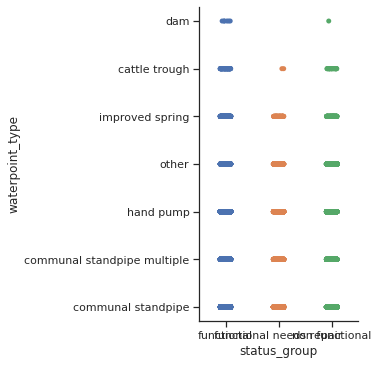

In [10]:
sns.catplot(y="waterpoint_type", x="status_group", data=train_df)

In [11]:
train_df["extraction_type_class"].value_counts(sort=True)

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [74]:
train_df["region"].value_counts(dropna=False,sort=True) 

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [13]:
#duplicate check
# train_df["quality_group"].value_counts(),train_df["water_quality"].value_counts()
# train_df["quantity"].value_counts(),train_df["quantity_group"].value_counts() 
# train_df["waterpoint_type"].value_counts(),train_df["waterpoint_type_group"].value_counts() 
# train_df["management"].value_counts(),train_df["management_group"].value_counts() 
# train_df["payment"].value_counts(),train_df["payment_type"].value_counts() 


In [14]:
train_df["amount_tsh"].std()

2997.574558143226

#Feature Eng

In [15]:
#booleans and missing default 0
train_df["permit_int"] = train_df["permit"].apply(lambda x: 1 if x else 0)
test_df["permit_int"] = test_df["permit"].apply(lambda x: 1 if x else 0)

train_df["public_meeting_int"] = train_df["public_meeting"].apply(lambda x: 1 if x else 0)
test_df["public_meeting_int"] = test_df["public_meeting"].apply(lambda x: 1 if x else 0)


In [385]:
#lon lat --> polar

#lon lat --> r
train_df["lon_lar_r"] = (train_df["longitude"]**2+train_df["latitude"]**2)**0.5
test_df["lon_lar_r"] = (test_df["longitude"]**2+test_df["latitude"]**2)**0.5

#lon lat --> tan
train_df["lon_lar_tan"] = (train_df["longitude"]+0.001)/(train_df["latitude"]+0.001)
test_df["lon_lar_tan"] = (test_df["longitude"]+0.001)/(test_df["latitude"]+0.001)

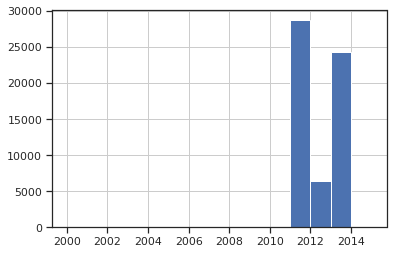

In [16]:
train_df["year"] = train_df["date_recorded"].apply(lambda x: int(x[0:4]))
test_df["year"] = test_df["date_recorded"].apply(lambda x: int(x[0:4]))

train_df["year"].hist(bins=range(2000,2016,1))

In [17]:
#missing default 1950
train_df["construction_year"].replace(0,1950,inplace=True)
test_df["construction_year"].replace(0,1950,inplace=True)

In [19]:
train_df["year_diff"] = train_df["year"] - train_df["construction_year"]
test_df["year_diff"] = test_df["year"] - test_df["construction_year"]

train_df["year_diff_sqr"] = (train_df["year"] - train_df["construction_year"])**2
test_df["year_diff_sqr"] = (test_df["year"] - test_df["construction_year"])**2

In [298]:
train_df["gps_height_sqr"] = train_df["gps_height"]**2
test_df["gps_height_sqr"] = test_df["gps_height"]**2

In [20]:
train_df = train_df.join( pd.get_dummies(train_df['extraction_type_class']))
test_df = test_df.join( pd.get_dummies(test_df['extraction_type_class']))

In [21]:
train_df = train_df.join( pd.get_dummies(train_df['basin'],prefix="basin"))
test_df = test_df.join( pd.get_dummies(test_df['basin'],prefix="basin"))

In [22]:
train_df = train_df.join( pd.get_dummies(train_df['quality_group'],prefix="qg"))
test_df = test_df.join( pd.get_dummies(test_df['quality_group'],prefix="qg"))

In [23]:
train_df = train_df.join( pd.get_dummies(train_df['waterpoint_type_group'],prefix="wp_type"))
test_df = test_df.join( pd.get_dummies(test_df['waterpoint_type_group'],prefix="wp_type"))

In [24]:
#ordinal (intuitively)
quantity_group_ord_enc_dict = {
                              'insufficient':-2,
                              'dry':-1,
                              'seasonal':1,
                              'enough':2,
                              'unknown':0
                              }


train_df["quantity_group_enc"] =train_df["quantity_group"].map(quantity_group_ord_enc_dict)
test_df["quantity_group_enc"] =test_df["quantity_group"].map(quantity_group_ord_enc_dict)

In [25]:
#ordinal (intuitively) disructive nature
souce_type_dict = {
                  'rainwater harvesting':-3,
                  'shallow well':-2,
                  'spring':-1,
                  'other':0,
                  'borehole':1,
                  'river/lake':2,
                  'dam':3,
                  }

train_df["source_type_enc"] = train_df["source_type"].map(souce_type_dict)
test_df["source_type_enc"] = test_df["source_type"].map(souce_type_dict)


In [26]:
souce_class_dict = {
                  'groundwater':-1,
                  'unknown':0,
                  'surface':1,
                  }

train_df["source_class_enc"] = train_df["source_class"].map(souce_class_dict)
test_df["source_class_enc"] = test_df["source_class"].map(souce_class_dict)

In [27]:
#ordinal based on frequency of payment and likelihood of no need for repair
payment_type_dict = {
                    'never pay':-2,
                    'annually':-1,
                    'unknown': 0 ,
                    'other': 0, 
                    'monthly':1,
                    'per bucket':2,
                    'on failure':3,
                  }

train_df["payment_type_enc"] = train_df["payment_type"].map(payment_type_dict)
test_df["payment_type_enc"] = test_df["payment_type"].map(payment_type_dict)

In [28]:
scheme_mgt_dict = {
                  'Trust':-3,
                  'Water Board':-2,
                  'Water authority':-2,
                  'VWC':-1,
                  'SWC':-1,
                  'WUG':-1, 
                  'WUA':-1, 
                  'Parastatal':-1,
                  'Other':0,
                  'None':0,
                  'Private operator':1, 
                  'Company':2,
                  }

train_df["scheme_management"].fillna('None',inplace=True)
test_df["scheme_management"].fillna('None',inplace=True)

train_df["scheme_mgt_enc"] = train_df["scheme_management"].map(scheme_mgt_dict)
test_df["scheme_mgt_enc"] = test_df["scheme_management"].map(scheme_mgt_dict)

In [29]:
#based on robustness
extraction_type_class_dict={
                          'rope pump':-3,
                          'handpump':-2,
                          'submersible':-1,
                          'motorpump':-1,
                          'other':0,
                          'wind-powered':1,
                          'gravity':2,
                        }
train_df["extraction_type_class_enc"] = train_df["extraction_type_class"].map(extraction_type_class_dict)
test_df["extraction_type_class_enc"] = test_df["extraction_type_class"].map(extraction_type_class_dict)

In [ ]:
# water_quality_dict = {
#                     'fluoride abandoned':-2,
#                     'coloured':-1,
#                     'salty abandoned':-2,
#                     'fluoride':-1,
#                     'salty':-1,
#                     'milky':-1,
#                     'unknown':0,  
#                     'soft':1
#                   }

# train_df["water_quality_enc"] = train_df["water_quality"].map(water_quality_dict)
# test_df["water_quality_enc"] = test_df["water_quality"].map(water_quality_dict)

In [30]:
def basin_type_enc(basin):
  base = basin.lower()
  if "lake" in base:
    return 1
  if "coast" in base:
    return -1
  return 0

train_df["basin_type_enc"] = train_df["basin"].apply(basin_type_enc) 
test_df["basin_type_enc"] = test_df["basin"].apply(basin_type_enc)

In [31]:
def management_group_enc(management_group):
  if management_group == "commercial":
    return 1
  if management_group == "parastatal":
    return -1
  if management_group == "user-group":
    return -2
  return 0

train_df["management_group_enc"] = train_df["management_group"].apply(management_group_enc) 
test_df["management_group_enc"] = test_df["management_group"].apply(management_group_enc)

In [32]:
train_df["installer_cust_enc"] = train_df["installer"].apply(lambda x: 1 if x=="DWE" else -1 if x=="Government" else 0)
test_df["installer_cust_enc"] = test_df["installer"].apply(lambda x: 1 if x=="DWE" else -1 if x=="Government" else 0)

numerical predictor

In [33]:
train_df["status_group_numerical"] = train_df["status_group"].apply(lambda x: 1 if x=="functional" else -1 if x=="non functional" else 0)
train_df["status_group_numerical"] = train_df["status_group_numerical"].astype("int64")

target encoding

In [456]:
train_df["amount_tsh"].replace(0,train_df["amount_tsh"].mean(),inplace=True)
test_df["amount_tsh"].replace(0,train_df["amount_tsh"].mean(),inplace=True)
# train_df["amount_tsh"].value_counts()

In [34]:
target_encoder = TargetEncoder()

train_df["basin_target_enc"] = target_encoder.fit_transform(train_df['basin'],train_df['status_group_numerical'])
test_df["basin_target_enc"] = target_encoder.transform(test_df['basin'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [35]:
target_encoder = TargetEncoder()

train_df["extraction_type_class_target_enc"] = target_encoder.fit_transform(train_df['extraction_type_class'],train_df['status_group_numerical'])
test_df["extraction_type_class_target_enc"] = target_encoder.transform(test_df['extraction_type_class'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
target_encoder = TargetEncoder()

train_df["installer_target_enc"] = target_encoder.fit_transform(train_df['installer'],train_df['status_group_numerical'])
test_df["installer_target_enc"] = target_encoder.transform(test_df['installer'])

In [ ]:
target_encoder = TargetEncoder()

train_df["scheme_management_target_enc"] = target_encoder.fit_transform(train_df['scheme_management'],train_df['status_group_numerical'])
test_df["scheme_management_target_enc"] = target_encoder.transform(test_df['scheme_management'])

In [77]:
target_encoder = TargetEncoder()

train_df["region_target_enc"] = target_encoder.fit_transform(train_df['region'],train_df['status_group_numerical'])
test_df["region_target_enc"] = target_encoder.transform(test_df['region'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
target_encoder = TargetEncoder()

train_df["source_class_target_enc"] = target_encoder.fit_transform(train_df['source_class'],train_df['status_group_numerical'])
test_df["source_class_target_enc"] = target_encoder.transform(test_df['source_class'])

#Train Test split and Feature Selection

In [ ]:
train_df.head()

In [178]:
train_df["rope_pump"] = train_df["rope pump"]
test_df["rope_pump"] = test_df["rope pump"]

In [457]:
features_list = [
                "amount_tsh",
                # "date_recorded",
                # "funder",
                "gps_height",
                # "installer",
                "longitude",
                "latitude",
                # "wpt_name",
                # "num_private", #????
                # "basin",
                # "subvillage",
                # "region", 
                "region_code",  
                "district_code", 
                # "lga",
                # "ward", 
                "population", 
                # "public_meeting",
                # "recorded_by",
                # "scheme_management",
                # "scheme_name", 
                # "permit", 
                "construction_year", 
                # "extraction_type", 
                # "extraction_type_group", 
                # "extraction_type_class", 
                # "management", 
                # "management_group", 
                #  --- duplicates --- 
                # "payment", # "payment_type",
                # "water_quality", # "quality_group",
                # "quantity", # "quantity_group",
                # "source", # "source_type", # "source_class",
                # "waterpoint_type", # "waterpoint_type_group",
                #  ----- custom -----
                 "year",
                 "permit_int",
                 "public_meeting_int",
                 "year_diff_sqr",
                 "year_diff",
                 "lon_lar_r",
                #  "lon_lar_tan",
                #  "gps_height_sqr",
                #  ---Basin dummies---
                #  'basin_Lake Nyasa','basin_Lake Victoria','basin_Pangani','basin_Ruvuma / Southern Coast','basin_Internal',
                #  'basin_Lake Tanganyika','basin_Wami / Ruvu','basin_Rufiji','basin_Lake Rukwa',
                #  --- extraction_type_class dummies ---
                 'gravity', 'submersible', 'handpump', 'other', 'motorpump','wind-powered', 'rope_pump',
                #  --- quality_group dummies
                #  'qg_good', 'qg_salty', 'qg_milky', 'qg_unknown', 'qg_fluoride', 'qg_colored',
                 "quantity_group_enc",
                 "source_type_enc",
                 "source_class_enc",
                #  "water_quality_enc",
                #  --- waterpoint_type_group dummies
                #  'wp_type_communal standpipe', 'wp_type_hand pump', 'wp_type_other',
                #  'wp_type_improved spring','wp_type_cattle trough', 'wp_type_dam',
                 "basin_type_enc",
                 "management_group_enc",
                 "payment_type_enc",
                 "scheme_mgt_enc",
                #  "installer_cust_enc",
                 "extraction_type_class_enc",
                 "basin_target_enc",
                 "extraction_type_class_target_enc",
                 "installer_target_enc",
                 "scheme_management_target_enc",
                 "region_target_enc",
                 "source_class_target_enc",
              ]



In [458]:
from sklearn.model_selection import train_test_split
X = train_df[features_list]
X_test = test_df[features_list]

y = lable_df["status_group"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=0)

In [459]:
X.head()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,year,permit_int,public_meeting_int,year_diff_sqr,year_diff,lon_lar_r,gravity,submersible,handpump,other,motorpump,wind-powered,rope_pump,quantity_group_enc,source_type_enc,source_class_enc,basin_type_enc,management_group_enc,payment_type_enc,scheme_mgt_enc,extraction_type_class_enc,basin_target_enc,extraction_type_class_target_enc,installer_target_enc,scheme_management_target_enc,region_target_enc,source_class_target_enc
0,6000.000000,1390,34.938093,-9.856322,11,5,109,1999,2011,0,1,144,12,36.301755,1,0,0,0,0,0,0,2,-1,-1,1,-2,-1,-1,2,0.356539,0.299365,0.287234,0.094067,0.587646,0.144495
1,317.650385,1399,34.698766,-2.147466,20,2,280,2010,2013,1,1,9,3,34.765155,1,0,0,0,0,0,0,-2,-3,1,1,-2,-2,0,2,0.091823,0.299365,0.692308,0.224543,-0.069578,0.208208
2,25.000000,686,37.460664,-3.821329,21,4,250,2009,2013,1,1,16,4,37.655065,1,0,0,0,0,0,0,2,3,1,0,-2,2,-1,2,0.255145,0.299365,0.441176,0.094067,0.307644,0.208208
3,317.650385,263,38.486161,-11.155298,90,63,58,1986,2013,1,1,729,27,40.070254,0,1,0,0,0,0,0,-1,1,-1,-1,-2,-2,-1,-1,-0.184064,0.118466,0.112613,0.094067,-0.321387,0.144495
4,317.650385,0,31.130847,-1.825359,18,1,0,1950,2011,1,1,3721,61,31.184316,1,0,0,0,0,0,0,1,-3,1,1,0,-2,0,2,0.091823,0.299365,0.155556,0.023981,0.133293,0.208208


#Model Selection and Training

RandomForestClassifier

In [460]:
from sklearn.ensemble import RandomForestClassifier

randf_clf = RandomForestClassifier(max_depth=14, 
                                   #criterion = "entropy",
                                   #class_weight="balanced",
                                   max_features="log2",
                                   bootstrap=False,
                                   random_state=0,
                                  )
randf_clf.fit(X_train, y_train)
# randf_clf.fit(X, y)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [461]:
randf_clf.score(X_train, y_train) # 0.87820

0.8768028544147947

In [462]:
#valid_acc: 0.68406 --> submission : 0.6811 rank ~4000
#valid_acc: 0.75732 --> submission : 0.7622 rank ~3600
#valid_acc: 0.77915 --> submission : 0.7857 rank ~3300
#valid_acc: 0.79522 --> submission : 0.7991 rank ~2973
#valid_acc: 0.79900 --> submission : 0.7997 rank ~ 

randf_clf.score(X_valid, y_valid) # 0.79976

0.7929292929292929

In [377]:
randf_clf.score(X, y) #with split : 0.8415 , w/o split:

0.8514814814814815

In [378]:
pred = randf_clf.predict(X_test)

In [379]:
pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

XGBoost

In [466]:
import xgboost

xgb_model = xgboost.XGBClassifier(
                                  # booster="gbtree",
                                  max_depth=12,
                                  seed=0,
                                  reg_alpha = 5,
                                  # reg_lambda = 2
                                  # n_estimators = 200
                                  )
# xgb_model.fit(X_train, y_train)
xgb_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=5, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=1, verbosity=1)

In [464]:
xgb_model.score(X_train, y_train) # 0.86903

0.8674053972561435

In [465]:
#valid_acc: 0.79619 --> submission : 0.8063 rank ~ 2550
#valid_acc: 0.80211 --> submission : 0.8028 rank ~ ---
#valid_acc: 0.804   --> submission : 0.8056 rank ~ ---

xgb_model.score(X_valid, y_valid) # 0.80364

0.8003775124987246

In [395]:
xgb_model.score(X, y) #with split : 0.85442 w/o split : 0.86479

0.8480976430976431

In [467]:
pred = xgb_model.predict(X_test)

In [468]:
pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

#Output 

In [469]:
test_df["status_group"] = pred
output_df = test_df[["id","status_group"]]

In [470]:
output_df.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [471]:
output_df.to_csv("output_xg_last.csv",index=False)

# post 


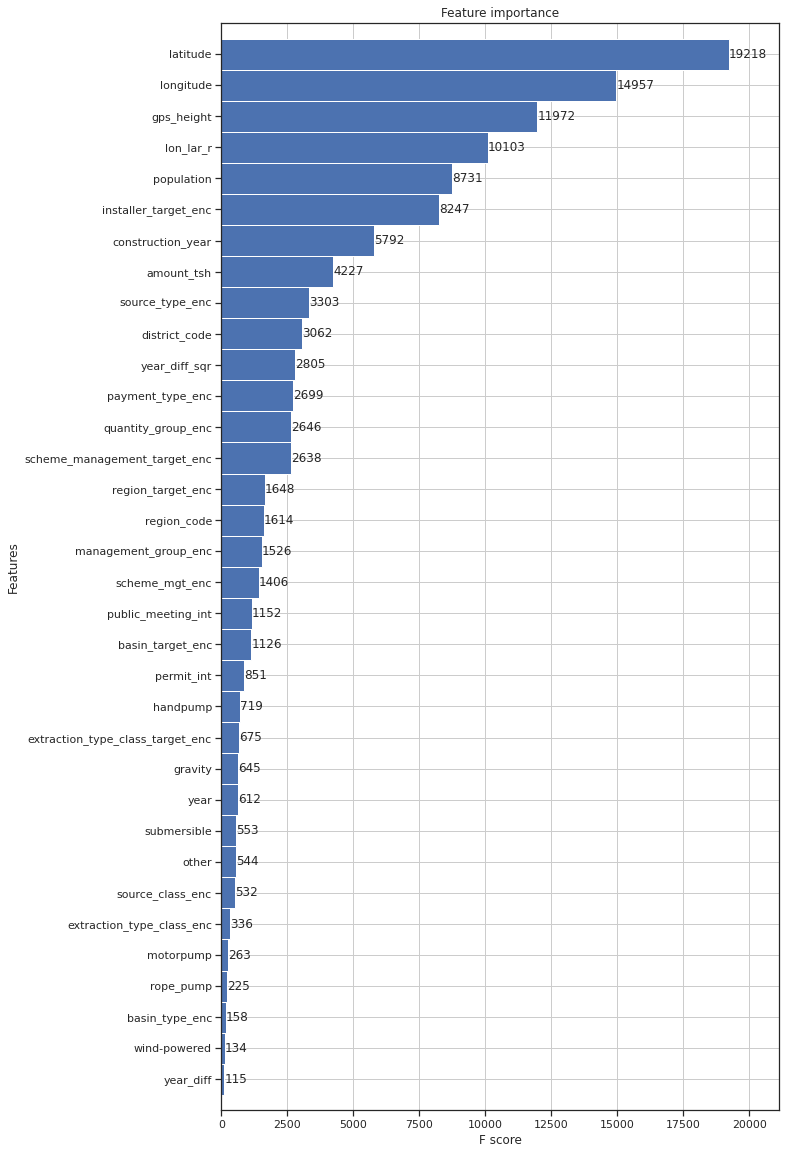

In [472]:
fig, ax = plt.subplots(figsize=(10, 20))
xgboost.plot_importance(xgb_model,height=1,ax=ax, importance_type="weight")

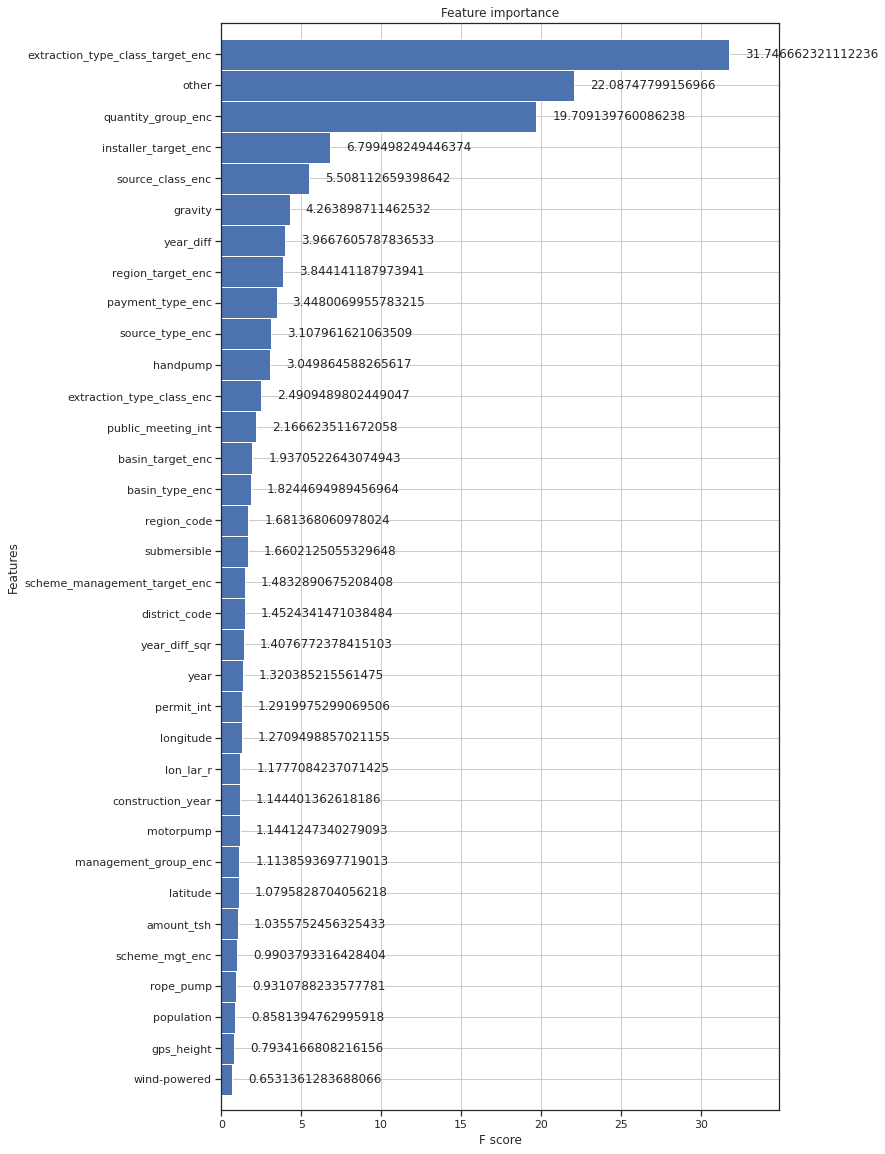

In [473]:
fig, ax = plt.subplots(figsize=(10, 20))
xgboost.plot_importance(xgb_model,height=1,ax=ax, importance_type="gain")

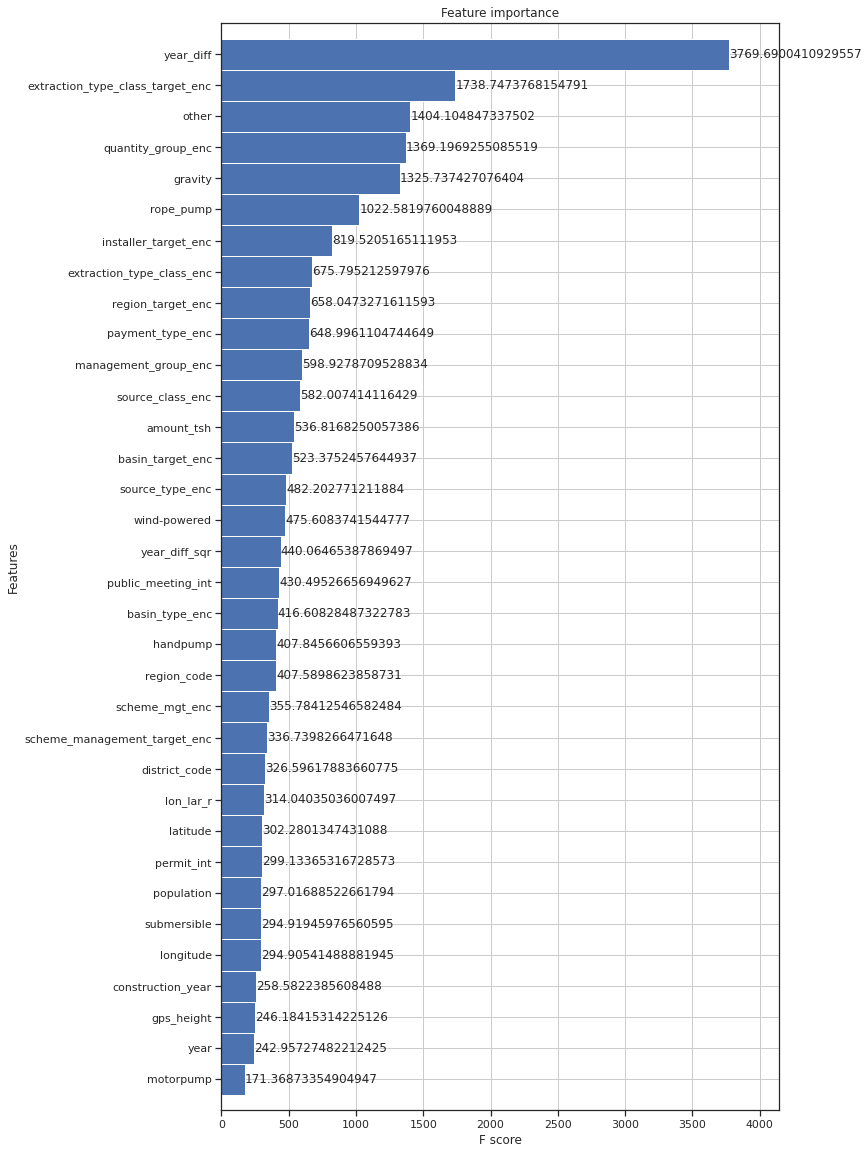

In [474]:
fig, ax = plt.subplots(figsize=(10, 20))
xgboost.plot_importance(xgb_model,height=1,ax=ax, importance_type="cover")

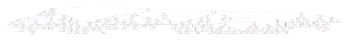

In [195]:
xgboost.plot_tree(xgb_model,num_trees=1)